# In this notebook we move to understanding the PySTAC API that will allow us to access various satellite datasets. Specifically, we will explore the Sentinel-2A dataset stored on the Planetary Computer.  

## We will follow the steps that we followed previously, but in terms of getting credentials and then identifying the data that was processed in the previous DEMO notebook.  

In [91]:
import os
import fsspec 
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pystac_client import Client
import planetary_computer as pc
import rasterio

import sys #need to add the current directory to import 
sys.path.append('/content')
#import the fluvius library
#from src.fluvius import WaterData, WaterStation
#from src.utils import generate_map

In [2]:
# reads the credential file
with open('/content/credentials') as credentials:
    f = credentials.readlines() #gets the individual lines
    
# now assign those values to os.environ as accessible variables
for var in f:
    key, value = var.split(' = ') 
    #be sure the ' = 'has a space before and after in the credentials file
    os.environ[key] = value.rstrip('\n')

# then we will store our keys into a variable called storage_options

storage_options={'account_name':os.environ['ACCOUNT_NAME'],\
                 'account_key':os.environ['BLOB_KEY'],
                 'connection_string': os.environ['CONNECTION_STRING']}

fs = fsspec.filesystem('az',\
                       account_name=storage_options['account_name'],\
                       account_key=storage_options['account_key'])   


In [5]:
# now given a particular dataset let us explore the data source
data_source = 'itv'
filename = f'az://modeling-data/{data_source}_data.csv'
df = pd.read_csv(filename,storage_options=storage_options)
#not the buffers here were established in the previous step to be
'''
spatial_buffer -> 500m surrounding point
temporal_buffer -> 8 days surrounding acquisition date
'''

'\nspatial_buffer -> 500m surrounding point\ntemporal_buffer -> 8 days surrounding acquisition date\n'

# Let's build an example function to allow us to open a PySTAC Client and search the planetarycomputer archive for sentinel-2-l2a data

In [60]:
import ast
def build_catalog(df, site_no, collection='sentinel-2-l2a'):
    ''' 
    Use pystac-client to search for Sentinel 2 L2A data
    '''
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    print(f'building catalog for station {site_no} with {collection}!')

    area_of_interest = ast.literal_eval(df[df['site_no']==site_no].AOI[0])
    time_of_interest = df[df['site_no']==site_no].TOI[0]
    search = catalog.search(
        collections=[collection], 
        intersects=area_of_interest, 
        datetime=time_of_interest
        )
    matched_list = list(search.get_items())
    print(f"{len(matched_list)} Items found")
    if  len(matched_list) == 0:
        catalog = None
    else:
        catalog = search
    return catalog


In [61]:
catalog = build_catalog(df, df.site_no[0])


building catalog for station ITV1 with sentinel-2-l2a!
322 Items found


# now we have a catalog for the particular site of our choosing which is an `item_search` object, from here we can get the items using the `get_items()` function which creates a generator object which we can loop through using list comprehension

In [70]:
items = [item for item in catalog.get_items()]

In [71]:
items

[<Item id=S2B_MSIL2A_20190903T134219_R124_T22MET_20201004T085733>,
 <Item id=S2A_MSIL2A_20190901T135111_R024_T22MET_20201004T075900>,
 <Item id=S2A_MSIL2A_20190829T134211_R124_T22MET_20201005T062143>,
 <Item id=S2B_MSIL2A_20190827T135119_R024_T22MET_20201005T054204>,
 <Item id=S2B_MSIL2A_20190824T134219_R124_T22MET_20201005T042658>,
 <Item id=S2A_MSIL2A_20190822T135111_R024_T22MET_20201005T032628>,
 <Item id=S2A_MSIL2A_20190819T134211_R124_T22MET_20201005T021427>,
 <Item id=S2B_MSIL2A_20190817T135119_R024_T22MET_20201005T013815>,
 <Item id=S2B_MSIL2A_20190814T134219_R124_T22MET_20201005T002638>,
 <Item id=S2A_MSIL2A_20190812T135121_R024_T22MET_20201004T232640>,
 <Item id=S2A_MSIL2A_20190809T134211_R124_T22MET_20201004T221559>,
 <Item id=S2B_MSIL2A_20190807T135119_R024_T22MET_20201004T214034>,
 <Item id=S2B_MSIL2A_20190804T134219_R124_T22MET_20201004T202933>,
 <Item id=S2A_MSIL2A_20190802T135121_R024_T22MET_20201004T193046>,
 <Item id=S2A_MSIL2A_20190730T134221_R124_T22MET_20201005T1959

## Looking at the first item we can see all the properties of the particular scene

In [77]:
items[0].properties

{'datetime': '2019-09-03T13:42:19.024000Z',
 'platform': 'Sentinel-2B',
 'proj:epsg': 32722,
 'instruments': ['msi'],
 's2:mgrs_tile': '22MET',
 'constellation': 'Sentinel 2',
 's2:granule_id': 'S2B_OPER_MSI_L2A_TL_ESRI_20201004T085736_A013020_T22MET_N02.12',
 'eo:cloud_cover': 18.786453,
 's2:datatake_id': 'GS2B_20190903T134219_013020_N02.12',
 's2:product_uri': 'S2B_MSIL2A_20190903T134219_N0212_R124_T22MET_20201004T085733.SAFE',
 's2:datastrip_id': 'S2B_OPER_MSI_L2A_DS_ESRI_20201004T085736_S20190903T134213_N02.12',
 's2:product_type': 'S2MSI2A',
 'sat:orbit_state': 'descending',
 's2:datatake_type': 'INS-NOBS',
 's2:generation_time': '2020-10-04T08:57:33.865Z',
 'sat:relative_orbit': 124,
 's2:water_percentage': 0.019451,
 's2:mean_solar_zenith': 28.1333707478047,
 's2:mean_solar_azimuth': 59.7572228888304,
 's2:processing_baseline': '02.12',
 's2:snow_ice_percentage': 0.0,
 's2:vegetation_percentage': 47.634774,
 's2:thin_cirrus_percentage': 13.516857,
 's2:cloud_shadow_percentage':

## As well as assets for which the reflectance data we are interested in can be drawn from

In [78]:
items[0].assets

{'AOT': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/ET/2019/09/03/S2B_MSIL2A_20190903T134219_N0212_R124_T22MET_20201004T085733.SAFE/GRANULE/L2A_T22MET_A013020_20190903T134213/IMG_DATA/R10m/T22MET_20190903T134219_AOT_10m.tif>,
 'B01': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/ET/2019/09/03/S2B_MSIL2A_20190903T134219_N0212_R124_T22MET_20201004T085733.SAFE/GRANULE/L2A_T22MET_A013020_20190903T134213/IMG_DATA/R60m/T22MET_20190903T134219_B01_60m.tif>,
 'B02': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/ET/2019/09/03/S2B_MSIL2A_20190903T134219_N0212_R124_T22MET_20201004T085733.SAFE/GRANULE/L2A_T22MET_A013020_20190903T134213/IMG_DATA/R10m/T22MET_20190903T134219_B02_10m.tif>,
 'B03': <Asset href=https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/22/M/ET/2019/09/03/S2B_MSIL2A_20190903T134219_N0212_R124_T22MET_20201004T085733.SAFE/GRANULE/L2A_T22MET_A013020_20190903T134213/IMG_DATA/R10m/T22MET_20

## we can select one of these assets such as 'B01' (or any other band or preview)


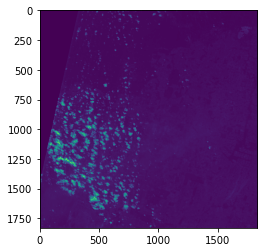

In [94]:
#note we have to sign the href in order to access from planetary computer
selected_item = items[0]
asset_name = 'B01'

href = pc.sign(selected_item.assets[asset_name].href)
img = rasterio.open(href).read()
#when we read the data it will be in order (bands, rows, cols)
plt.imshow(np.moveaxis(img,0,-1))

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


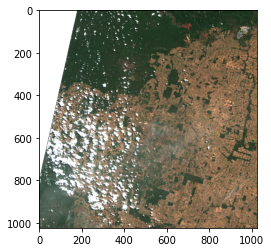

In [97]:
#we can try again with a different asset
asset_name = 'rendered_preview'
href = pc.sign(selected_item.assets[asset_name].href)
img = rasterio.open(href).read()
#when we read the data it will be in order (bands, rows, cols)
plt.imshow(np.moveaxis(img,0,-1))